In [1]:
%cd "~/moses-incons-pen-xp"
%load_ext autoreload
%autoreload 2

/home/xabush/moses-incons-pen-xp


In [2]:
import numpy as np
import pandas as pd
import scipy
import math
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
import math
from sklearn.model_selection import train_test_split
from datetime import datetime
from notebooks.manifold_reg.util import *
from notebooks.manifold_reg.custom_model import *

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
assoc_mat = get_assoc_mat(20, 10)
assoc_mat.shape

(220, 220)

Generate a dataset with the assumption of logistic regression. ie. logit($y$) = $X$$\beta$

In [5]:
X, beta, y_log = generate_log_data(20, 10, tf_on=4, val_tf=[5, 5, 5, 5], n=100)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.5, random_state=42, stratify=y_log)

In [578]:
save_gen_file(X_train, y_train, "data/Li2008", "beta1_train", 15, 10)
save_gen_file(X_test, y_test, "data/Li2008", "beta1_test", 15, 10)

In [7]:
n_iter = 20
l1_vals = np.logspace(-2, 0, n_iter)
# l1_vals = np.concatenate([np.array([0]), l1_vals])
l2_vals = np.logspace(-4, 1, n_iter)
# l2_vals = np.concatenate([np.array([0]), l2_vals])
gammas = np.logspace(-2, 3, 15)

Find gamma parameters and check log-loss for continuous dataset

In [21]:
from sklearn.model_selection import KFold, StratifiedKFold
from notebooks.manifold_reg.util import solve_logistic_reg
from datetime import datetime

# train_errs_1 = np.zeros(len(gammas))
train_errs_cv_1 = np.zeros(len(gammas))
test_errs_1 = np.zeros(len(gammas))
# beta_vals_cv_1 = np.zeros((len(gammas), n_iter, n_iter, X_train.shape[1]))
beta_vals_1 = np.zeros((len(gammas), X_train.shape[1]))

train_ll_pen, test_ll_pen = np.zeros(len(gammas)), np.zeros(len(gammas))
train_l1_pen, test_l1_pen = np.zeros(len(gammas)), np.zeros(len(gammas))
train_l2_pen, test_l2_pen = np.zeros(len(gammas)), np.zeros(len(gammas))
min_l1_vals, min_l2_vals = np.zeros(len(gammas)), np.zeros(len(gammas))

n_folds = 5
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for i, g in enumerate(gammas):
    fold_test_errs_1 = np.zeros((n_folds, n_iter, n_iter))
    fold_beta_vals_1 = np.zeros((n_folds, n_iter, n_iter, X_train.shape[1]))
    fold_ll_pen = np.zeros((n_folds, n_iter, n_iter))
    fold_l1_pen = np.zeros((n_folds, n_iter, n_iter))
    fold_l2_pen = np.zeros((n_folds, n_iter, n_iter))
    j = 0
    print(f"[{datetime.now()}] - gamma - {g:.2f}")
    for train_idx, test_idx in cv.split(X_train, y_train):
        x_train_cv, x_test_cv = X_train[train_idx], X_train[test_idx]
        y_train_cv, y_test_cv = y_train[train_idx], y_train[test_idx]
        _,  fold_test_errs_1[j], fold_beta_vals_1[j],\
                fold_ll_pen[j], fold_l1_pen[j], fold_l2_pen[j] = solve_logistic_reg(x_train_cv, x_test_cv, y_train_cv, y_test_cv, l1_vals, l2_vals, g, assoc_mat)

        j += 1
    fold_cv_err = np.mean(fold_test_errs_1, axis=0)
    min_idx = np.unravel_index(np.argmin(fold_cv_err), fold_cv_err.shape)

    train_errs_cv_1[i] = fold_cv_err[min_idx]
    train_ll_pen[i] = np.mean(fold_ll_pen, axis=0)[min_idx]
    train_l1_pen[i] = np.mean(fold_l1_pen, axis=0)[min_idx]
    train_l2_pen[i] = np.mean(fold_l2_pen, axis=0)[min_idx]


    min_l1_val, min_l2_val = l1_vals[min_idx[0]], l2_vals[min_idx[1]]
    min_l2_vals[i] = min_l1_val
    min_l2_vals[i] = min_l2_val
    print(f"Min l1: {min_l1_val}, Min l2: {min_l2_val}")
    _, test_errs_1[i], beta_vals_1[i],\
       test_ll_pen[i], test_l1_pen[i], test_l2_pen[i] = apply_logisitc_reg(X_train, X_test, y_train, y_test, min_l1_val, min_l2_val, g, assoc_mat)


[2022-02-09 21:58:35.851982] - gamma - 0.01
Min l1: 0.01, Min l2: 0.0001
[2022-02-09 21:59:39.380100] - gamma - 0.02
Min l1: 0.01, Min l2: 0.0001
[2022-02-09 22:00:42.868802] - gamma - 0.05
Min l1: 0.01, Min l2: 0.0001
[2022-02-09 22:01:46.238567] - gamma - 0.12
Min l1: 0.01, Min l2: 0.0001
[2022-02-09 22:02:49.808863] - gamma - 0.27


/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWa

Min l1: 0.01, Min l2: 0.0001
[2022-02-09 22:04:03.239454] - gamma - 0.61


/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWa

Min l1: 0.01, Min l2: 0.0001
[2022-02-09 22:05:18.118609] - gamma - 1.39
Min l1: 0.01, Min l2: 0.012742749857031334
[2022-02-09 22:06:26.272395] - gamma - 3.16


/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/pyth

Min l1: 0.0206913808111479, Min l2: 0.0001
[2022-02-09 22:07:34.556205] - gamma - 7.20
Min l1: 0.08858667904100823, Min l2: 0.0001
[2022-02-09 22:08:41.900448] - gamma - 16.38
Min l1: 0.06951927961775606, Min l2: 0.0001
[2022-02-09 22:09:50.031638] - gamma - 37.28
Min l1: 0.06951927961775606, Min l2: 0.0001
[2022-02-09 22:10:58.592219] - gamma - 84.83
Min l1: 0.06951927961775606, Min l2: 0.0001
[2022-02-09 22:12:06.812296] - gamma - 193.07
Min l1: 0.06951927961775606, Min l2: 0.0001
[2022-02-09 22:13:15.278628] - gamma - 439.40
Min l1: 0.06951927961775606, Min l2: 0.0001
[2022-02-09 22:14:24.012460] - gamma - 1000.00
Min l1: 0.06951927961775606, Min l2: 0.0001


In [22]:
test_errs_1

array([0.33154718, 0.33154718, 0.33154718, 0.33154718, 0.33153455,
       0.33154485, 0.33154678, 0.30713237, 0.36539605, 0.49771164,
       0.5327562 , 0.53954245, 0.54085271, 0.54110428, 0.54115284])

In [39]:
res_1 = {"gamma": [], "min_train_err_cv": [], "l1_train_cv": [], "l2_train_cv": [],
         "ll_pen_train_cv": [], "l1_pen_train_cv": [], "l2_pen_train_cv":[],
         "test_err": [], "ll_pen_test": [], "l1_pen_test": [], "l2_pen_test": []
         }

for i, g in enumerate(gammas):
    res_1["gamma"].append(g)
    res_1["min_train_err_cv"].append(train_errs_cv_1[i])
    res_1["l1_train_cv"].append(min_l1_vals[i])
    res_1["l2_train_cv"].append(min_l2_vals[i])
    res_1["ll_pen_train_cv"].append(train_ll_pen[i])
    res_1["l1_pen_train_cv"].append(train_l1_pen[i])
    res_1["l2_pen_train_cv"].append(train_l2_pen[i])

    res_1["test_err"].append(test_errs_1[i])
    res_1["ll_pen_test"].append(test_ll_pen[i])
    res_1["l1_pen_test"].append(test_l1_pen[i])
    res_1["l2_pen_test"].append(test_l2_pen[i])

In [40]:
res_1_df = pd.DataFrame(res_1)
res_1_df

,gamma,min_train_err_cv,l1_train_cv,l2_train_cv,ll_pen_train_cv,l1_pen_train_cv,l2_pen_train_cv,test_err,ll_pen_test,l1_pen_test,l2_pen_test
0,0.010000,0.162820,0.0,0.000100,-0.006826,3.029151,0.000000e+00,0.331547,-0.007417,3.190571,0.000000e+00
1,0.022758,0.162820,0.0,0.000100,-0.006826,3.029151,0.000000e+00,0.331547,-0.007417,3.190571,0.000000e+00
2,0.051795,0.162820,0.0,0.000100,-0.006826,3.029151,0.000000e+00,0.331547,-0.007417,3.190571,0.000000e+00
3,0.117877,0.162820,0.0,0.000100,-0.006826,3.029151,0.000000e+00,0.331547,-0.007417,3.190571,0.000000e+00
4,0.268270,0.162865,0.0,0.000100,-0.006831,3.028647,-3.429472e-135,0.331535,-0.007420,3.190202,-9.001165e-271
5,0.610540,0.162798,0.0,0.000100,-0.006827,3.029080,-1.611205e-25,0.331545,-0.007417,3.190555,-3.101895e-51
6,1.389495,0.162806,0.0,0.012743,-0.006827,3.029037,6.641539e-05,0.331547,-0.007417,3.190575,2.793728e-10
7,3.162278,0.198740,0.0,0.000100,-0.020046,2.330988,1.072067e+02,0.307132,-0.015479,2.646038,3.750407e+00
8,7.196857,0.372269,0.0,0.000100,-0.221897,0.804576,9.538911e+02,0.365396,-0.172259,0.982131,7.604200e+02
9,16.378937,0.457238,0.0,0.000100,-0.339577,0.580308,1.077219e+03,0.497712,-0.375817,0.525984,1.015384e+03


In [30]:
res_1_df.to_csv("data/Li2008/gamma_l1_l2_pen_2200.csv", index=False)

In [31]:
X_2, beta_2, y_log_2 = generate_log_data(200, 10, tf_on=4, val_tf=[5, 5, 5, 5], n=100)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_log_2, test_size=0.5, random_state=42, stratify=y_log_2)

In [32]:
assoc_mat_2 = get_assoc_mat(200, 10)
assoc_mat_2.shape

(2200, 2200)

In [41]:
from sklearn.model_selection import KFold, StratifiedKFold
from notebooks.manifold_reg.util import solve_logistic_reg
from datetime import datetime

# train_errs_1 = np.zeros(len(gammas))
train_errs_cv_2 = np.zeros(len(gammas))
test_errs_2 = np.zeros(len(gammas))
# beta_vals_cv_1 = np.zeros((len(gammas), n_iter, n_iter, X_train.shape[1]))
beta_vals_2 = np.zeros((len(gammas), X_train_2.shape[1]))

train_ll_pen_2, test_ll_pen_2 = np.zeros(len(gammas)), np.zeros(len(gammas))
train_l1_pen_2, test_l1_pen_2 = np.zeros(len(gammas)), np.zeros(len(gammas))
train_l2_pen_2, test_l2_pen_2 = np.zeros(len(gammas)), np.zeros(len(gammas))
min_l1_vals_2, min_l2_vals_2 = np.zeros(len(gammas)), np.zeros(len(gammas))

n_folds = 5
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for i, g in enumerate(gammas):
    fold_test_errs_2 = np.zeros((n_folds, n_iter, n_iter))
    fold_beta_vals_2 = np.zeros((n_folds, n_iter, n_iter, X_train_2.shape[1]))
    fold_ll_pen_2 = np.zeros((n_folds, n_iter, n_iter))
    fold_l1_pen_2 = np.zeros((n_folds, n_iter, n_iter))
    fold_l2_pen_2 = np.zeros((n_folds, n_iter, n_iter))
    j = 0
    print(f"[{datetime.now()}] - gamma - {g:.2f}")
    for train_idx, test_idx in cv.split(X_train_2, y_train_2):
        x_train_2_cv, x_test_2_cv = X_train_2[train_idx], X_train_2[test_idx]
        y_train_2_cv, y_test_2_cv = y_train_2[train_idx], y_train_2[test_idx]
        _,  fold_test_errs_2[j], fold_beta_vals_2[j],\
                fold_ll_pen_2[j], fold_l1_pen_2[j], fold_l2_pen_2[j] = solve_logistic_reg(x_train_2_cv, x_test_2_cv, y_train_2_cv, y_test_2_cv, l1_vals, l2_vals, g, assoc_mat_2)

        j += 1

    fold_cv_err_2 = np.mean(fold_test_errs_2, axis=0)
    min_idx = np.unravel_index(np.argmin(fold_cv_err_2), fold_cv_err_2.shape)

    train_errs_cv_2[i] = fold_cv_err_2[min_idx]
    train_ll_pen_2[i] = np.mean(fold_ll_pen_2, axis=0)[min_idx]
    train_l1_pen_2[i] = np.mean(fold_l1_pen_2, axis=0)[min_idx]
    train_l2_pen_2[i] = np.mean(fold_l2_pen_2, axis=0)[min_idx]


    min_l1_val, min_l2_val = l1_vals[min_idx[0]], l2_vals[min_idx[1]]
    min_l1_vals_2[i] = min_l1_val
    min_l2_vals_2[i] = min_l2_val
    print(f"Min l1: {min_l1_val}, Min l2: {min_l2_val}")
    _, test_errs_2[i], beta_vals_2[i],\
       test_ll_pen_2[i], test_l1_pen_2[i], test_l2_pen_2[i] = apply_logisitc_reg(X_train_2, X_test_2, y_train_2, y_test_2, min_l1_val, min_l2_val, g, assoc_mat_2)

[2022-02-10 10:47:57.964966] - gamma - 0.01
Min l1: 0.37926901907322497, Min l2: 0.0001
[2022-02-10 10:56:11.823969] - gamma - 0.02
Min l1: 0.37926901907322497, Min l2: 0.0001
[2022-02-10 11:04:32.434779] - gamma - 0.05


/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWa

Min l1: 0.37926901907322497, Min l2: 0.0001
[2022-02-10 11:18:11.759188] - gamma - 0.12


/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWa

Min l1: 0.37926901907322497, Min l2: 0.0001
[2022-02-10 11:32:14.883564] - gamma - 0.27


/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/atoms/quad_form.py:212: UserWa

Min l1: 0.37926901907322497, Min l2: 5.455594781168514
[2022-02-10 11:42:52.665253] - gamma - 0.61


/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Min l1: 0.14384498882876628, Min l2: 0.0006158482110660267
[2022-02-10 11:51:20.790638] - gamma - 1.39


/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/pyth

Min l1: 0.01, Min l2: 0.0001
[2022-02-10 12:02:00.381760] - gamma - 3.16


/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/pyth

Min l1: 0.01, Min l2: 0.0001
[2022-02-10 12:13:59.326789] - gamma - 7.20


/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/pyth

Min l1: 0.01, Min l2: 0.0001
[2022-02-10 12:26:36.932754] - gamma - 16.38


/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/pyth

Min l1: 0.01, Min l2: 0.0001
[2022-02-10 12:39:20.342384] - gamma - 37.28


/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/pyth

Min l1: 0.01, Min l2: 0.0001
[2022-02-10 12:52:14.770525] - gamma - 84.83


/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/pyth

Min l1: 0.01, Min l2: 0.0001
[2022-02-10 13:04:51.663998] - gamma - 193.07


/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/pyth

Min l1: 0.01, Min l2: 0.0001
[2022-02-10 13:17:27.185862] - gamma - 439.40


/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/pyth

Min l1: 0.01, Min l2: 0.0001
[2022-02-10 13:30:11.934381] - gamma - 1000.00


/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/xabush/miniconda3/lib/pyth

Min l1: 0.01, Min l2: 0.0001


In [44]:
res_2 = {"gamma": [], "min_train_err_cv": [], "l1_train_cv": [], "l2_train_cv": [],
         "ll_pen_train_cv": [], "l1_pen_train_cv": [], "l2_pen_train_cv":[],
         "test_err": [],
         "ll_pen_test": [], "l1_pen_test": [], "l2_pen_test": []
         }

for i, g in enumerate(gammas):
    res_2["gamma"].append(g)
    res_2["min_train_err_cv"].append(train_errs_cv_2[i])
    res_2["l1_train_cv"].append(min_l1_vals_2[i])
    res_2["l2_train_cv"].append(min_l2_vals_2[i])
    res_2["ll_pen_train_cv"].append(train_ll_pen_2[i])
    res_2["l1_pen_train_cv"].append(train_l1_pen_2[i])
    res_2["l2_pen_train_cv"].append(train_l2_pen_2[i])

    res_2["test_err"].append(test_errs_2[i])
    res_2["ll_pen_test"].append(test_ll_pen_2[i])
    res_2["l1_pen_test"].append(test_l1_pen_2[i])
    res_2["l2_pen_test"].append(test_l2_pen_2[i])


res_2_df = pd.DataFrame(res_2)
res_2_df

,gamma,min_train_err_cv,l1_train_cv,l2_train_cv,ll_pen_train_cv,l1_pen_train_cv,l2_pen_train_cv,test_err,ll_pen_test,l1_pen_test,l2_pen_test
0,0.010000,0.631862,0.0,0.000100,-0.060301,0.423005,0.000000e+00,0.796039,-0.067532,0.450881,0.000000e+00
1,0.022758,0.631862,0.0,0.000100,-0.060301,0.423005,0.000000e+00,0.796039,-0.067532,0.450881,0.000000e+00
2,0.051795,0.631864,0.0,0.000100,-0.060297,0.423014,-1.359156e-215,0.796039,-0.067532,0.450881,0.000000e+00
3,0.117877,0.631848,0.0,0.000100,-0.060304,0.422997,-2.210211e-41,0.796029,-0.067537,0.450867,-1.200664e-65
4,0.268270,0.631861,0.0,5.455595,-0.060301,0.423005,2.691685e-07,0.796039,-0.067532,0.450881,8.572109e-13
5,0.610540,0.630606,0.0,0.000616,-0.059236,0.428568,7.981708e+01,0.864684,-0.029318,0.598216,1.170555e+01
6,1.389495,0.641613,0.0,0.000100,-0.199577,0.234421,1.352554e+03,0.737455,-0.185293,0.275728,1.330441e+03
7,3.162278,0.653875,0.0,0.000100,-0.310983,0.157410,1.337644e+03,0.708850,-0.364071,0.143793,1.246254e+03
8,7.196857,0.656503,0.0,0.000100,-0.335090,0.144030,1.301762e+03,0.705939,-0.402759,0.123028,1.154073e+03
9,16.378937,0.657014,0.0,0.000100,-0.339796,0.141515,1.293649e+03,0.705456,-0.410167,0.119244,1.134201e+03


In [45]:
min_l1_vals

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [801]:
res_2_df.to_csv("data/Li2008/gamma_l1_l2_pen_220.csv", index=False)

In [828]:
res_2_df

,gamma,min_train_err_cv,l1_train_cv,l2_train_cv,ll_pen_train_cv,l1_pen_train_cv,l2_pen_train_cv,min_test_err,l1_test,l2_test,ll_pen_test,l1_pen_test,l2_pen_test
0,0.010000,0.399356,0.112884,0.000000,-0.059398,1.257244,0.000000e+00,0.391732,0.088587,545.559478,-0.052313,1.457762,0.000000e+00
1,0.022758,0.399356,0.112884,0.000000,-0.059398,1.257244,0.000000e+00,0.391732,0.088587,545.559478,-0.052313,1.457762,0.000000e+00
2,0.051795,0.399356,0.112884,0.000000,-0.059398,1.257244,0.000000e+00,0.391732,0.088587,545.559478,-0.052313,1.457762,0.000000e+00
3,0.117877,0.399384,0.112884,0.033598,-0.059397,1.257249,-7.234538e-256,0.391732,0.088587,545.559478,-0.052313,1.457762,0.000000e+00
4,0.268270,0.399384,0.112884,0.018330,-0.059397,1.257249,-5.980063e-49,0.391732,0.088587,545.559478,-0.052313,1.457764,-2.808110e-83
5,0.610540,0.399356,0.112884,0.000000,-0.059397,1.257244,4.852836e-10,0.391732,0.088587,0.000000,-0.052313,1.457760,-3.167752e-15
6,1.389495,0.373034,0.088587,0.033598,-0.086955,1.302809,1.836987e+00,0.391732,0.088587,0.000000,-0.052313,1.457760,4.676294e-02
7,3.162278,0.664764,0.000000,0.000000,-0.001395,3.832029,9.721256e+03,0.419375,0.069519,0.000000,-0.176716,1.418550,5.726791e+02
8,7.196857,0.596762,0.000000,0.000000,-0.002893,3.392241,3.724555e+04,0.669223,0.000000,0.000000,-0.001487,4.333928,5.361992e+04
9,16.378937,0.582513,0.000000,0.000000,-0.003003,3.348320,5.022416e+04,0.625326,0.000000,0.000000,-0.002825,3.929799,7.522053e+04


In [763]:
train_min_idx_2 = np.unravel_index(np.argmin(train_errs_cv_2), train_errs_cv_2.shape)
test_min_idx_2 = np.unravel_index(np.argmin(test_errs_2), test_errs_2.shape)
print(f"Min train idx: {train_min_idx_2}, Min test idx: {test_min_idx_2}")
print(f"Min train error: {train_errs_cv_2[train_min_idx_2]}, gamma: {gammas[train_min_idx_2[0]]}, l1_val: {l1_vals[train_min_idx_2[1]]}, l2_val: {l2_vals[train_min_idx_2[2]]}\n"
      f"Min test errors: {test_errs_2[test_min_idx_2]}, gamma: {gammas[test_min_idx_2[0]]}, l1_val: {l1_vals[test_min_idx_2[1]]}, l2_val: {l2_vals[test_min_idx_2[2]]}")

Min train idx: (6, 10, 3), Min test idx: (6, 10, 0)
Min train error: 0.3730342044824204, gamma: 1.3894954943731375, l1_val: 0.08858667904100823, l2_val: 0.03359818286283781
Min test errors: 0.3917315496112382, gamma: 1.3894954943731375, l1_val: 0.08858667904100823, l2_val: 0.0


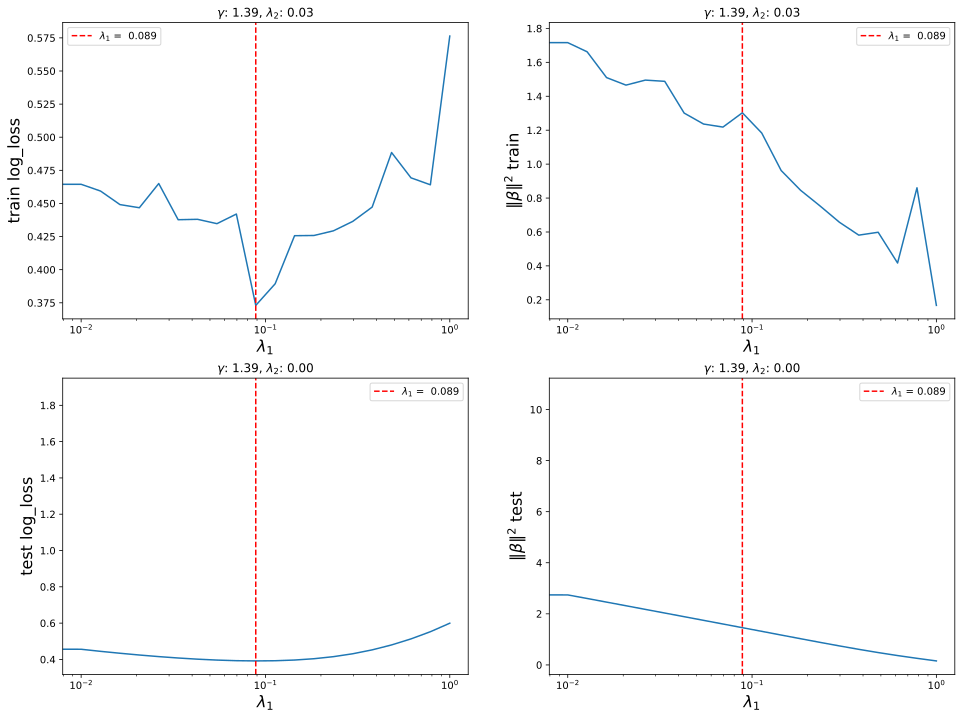

In [845]:
plot_lambda_vals(gammas, train_errs_cv_2, test_errs_2, train_l1_pen_2, test_l1_pen_2, l1_vals, l2_vals)

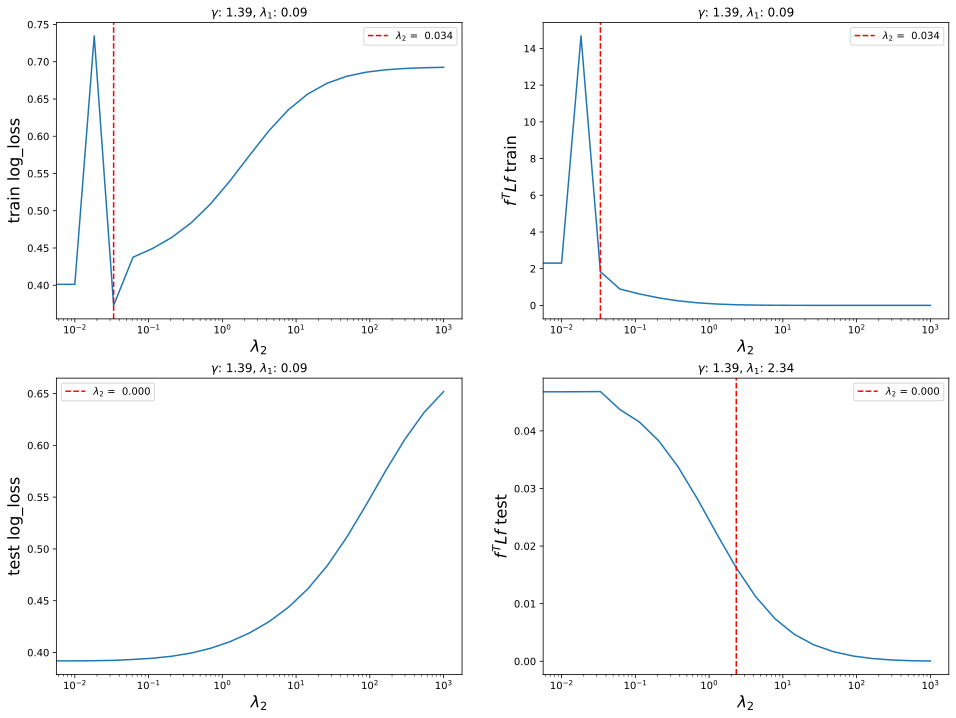

In [846]:
plot_lambda_vals(gammas, train_errs_cv_2, test_errs_2, train_l2_pen_2, test_l2_pen_2, l1_vals, l2_vals, l1=False)

In [ ]:
from notebooks.manifold_reg.util import solve_logistic_reg

train_errs_3 = np.zeros((len(gammas), n_iter, n_iter))
train_errs_cv_3 = np.zeros((len(gammas), n_iter, n_iter))
test_errs_3 = np.zeros((len(gammas), n_iter, n_iter))
beta_vals_cv_3 = np.zeros((len(gammas), n_iter, n_iter, X_train_2.shape[1]))
beta_vals_3 = np.zeros((len(gammas), n_iter, n_iter, X_train_2.shape[1]))

train_ll_pen_3, test_ll_pen_3 = np.zeros((len(gammas), n_iter, n_iter)), np.zeros((len(gammas), n_iter, n_iter))
train_l1_pen_3, test_l1_pen_3 = np.zeros((len(gammas), n_iter, n_iter)), np.zeros((len(gammas), n_iter, n_iter))
train_l2_pen_3, test_l2_pen_3 = np.zeros((len(gammas), n_iter, n_iter)), np.zeros((len(gammas), n_iter, n_iter))

n_folds = 5
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for i, g in enumerate(gammas):
    fold_test_errs_3 = np.zeros((n_folds, n_iter, n_iter))
    fold_beta_vals_3 = np.zeros((n_folds, n_iter, n_iter, X_train_2.shape[1]))
    fold_ll_pen_3 = np.zeros((n_folds, n_iter, n_iter))
    fold_l1_pen_3 = np.zeros((n_folds, n_iter, n_iter))
    fold_l2_pen_3 = np.zeros((n_folds, n_iter, n_iter))
    j = 0
    print(f"[{datetime.now()}] - gamma - {g:.2f}")
    for train_idx, test_idx in cv.split(X_train_2, y_train_2):
        x_train_3_cv, x_test_3_cv = X_train_2[train_idx], X_train_2[test_idx]
        y_train_3_cv, y_test_3_cv = y_train_2[train_idx], y_train_2[test_idx]
        _,  fold_test_errs_3[j], fold_beta_vals_3[j],\
                fold_ll_pen_3[j], fold_l1_pen_3[j], fold_l2_pen_3[j] = solve_logistic_reg(x_train_3_cv, x_test_3_cv, y_train_3_cv, y_test_3_cv, l1_vals, l2_vals, g, assoc_mat_2, n_iter=n_iter)

        j += 1
    train_errs_cv_3[i] = np.mean(fold_test_errs_3, axis=0)
    beta_vals_cv_3[i] = np.mean(fold_beta_vals_3, axis=0)
    train_ll_pen_3[i] = np.mean(fold_ll_pen_3, axis=0)
    train_l1_pen_3[i] = np.mean(fold_l1_pen_3, axis=0)

    train_l2_pen_3[i] = np.mean(fold_l2_pen_3, axis=0)
    train_errs_3[i], test_errs_3[i], beta_vals_3[i],\
       test_ll_pen_3[i], test_l1_pen_3[i], test_l2_pen_3[i] = solve_logistic_reg(X_train_2, X_test_2, y_train_2, y_test_2, l1_vals, l2_vals, g, assoc_mat_2, n_iter=n_iter)

[2022-02-07 13:01:51.867273] - gamma - 0.01
[2022-02-07 13:03:04.210724] - gamma - 0.02
[2022-02-07 13:04:16.142932] - gamma - 0.05
[2022-02-07 13:05:28.689115] - gamma - 0.12
[2022-02-07 13:11:39.551114] - gamma - 0.27


In [857]:
train_min_idx_3 = np.unravel_index(np.argmin(train_errs_cv_3), train_errs_cv_3.shape)
test_min_idx_3 = np.unravel_index(np.argmin(test_errs_3), test_errs_3.shape)
print(f"Min train idx: {train_min_idx_3}, Min test idx: {test_min_idx_3}")
print(f"Min train error: {train_errs_cv_3[train_min_idx_3]}, gamma: {gammas[train_min_idx_3[0]]}, l1_val: {l1_vals[train_min_idx_3[1]]}, l2_val: {l2_vals[train_min_idx_3[2]]}\n"
      f"Min test errors: {test_errs_3[test_min_idx_3]}, gamma: {gammas[test_min_idx_3[0]]}, l1_val: {l1_vals[test_min_idx_3[1]]}, l2_val: {l2_vals[test_min_idx_3[2]]}")

Min train idx: (13, 2, 0), Min test idx: (6, 8, 0)
Min train error: 0.3552023876937276, gamma: 439.3970560760795, l1_val: 0.012742749857031334, l2_val: 0.0
Min test errors: 0.34834381254235325, gamma: 1.3894954943731375, l1_val: 0.0545559478116852, l2_val: 0.0


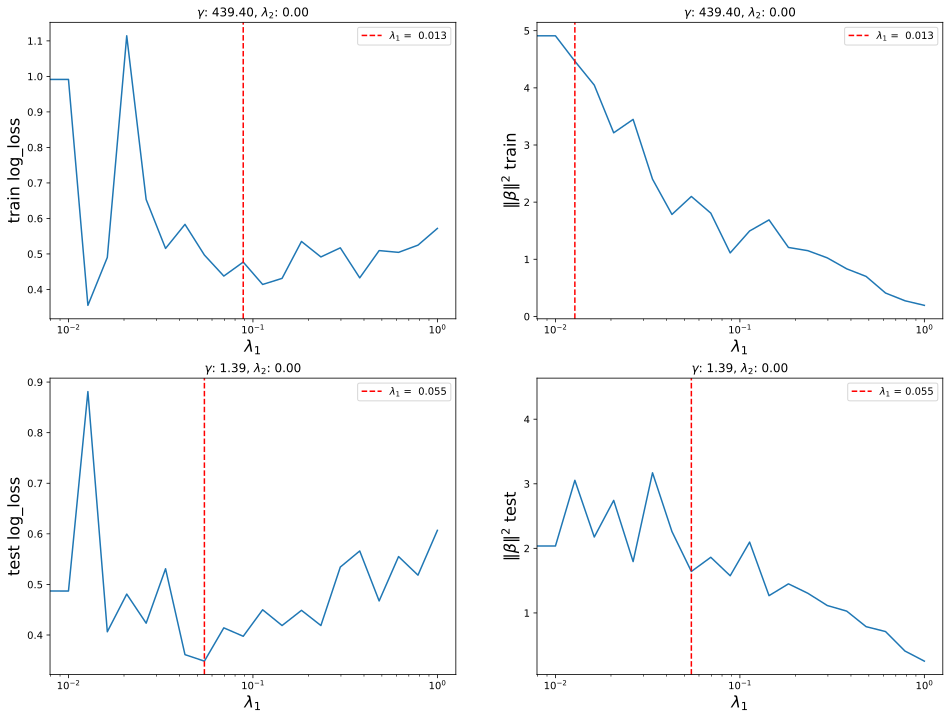

In [858]:
plot_lambda_vals(gammas, train_errs_cv_3, test_errs_3, train_l1_pen_3, test_l1_pen_3, l1_vals, l2_vals)

In [22]:
plot_lambda_vals(gammas, train_errs_cv_3, test_errs_3, train_l2_pen_3, test_l2_pen_3, l1_vals, l2_vals, l1=False)

NameError: name 'train_errs_cv_3' is not defined

In [881]:
res_3 = {"gamma": [], "min_train_err_cv": [], "l1_train_cv": [], "l2_train_cv": [],
         "ll_pen_train_cv": [], "l1_pen_train_cv": [], "l2_pen_train_cv":[],
         "min_test_err": [], "l1_test": [], "l2_test": [],
         "ll_pen_test": [], "l1_pen_test": [], "l2_pen_test": []
         }

for i, g in enumerate(gammas):
    res_3["gamma"].append(g)
    tr_idx = np.unravel_index(np.argmin(train_errs_cv_3[i]), train_errs_cv_3[i].shape)
    te_idx = np.unravel_index(np.argmin(test_errs_3[i]), test_errs_3[i].shape)
    print(f"gamma: {g}, min train idx: {tr_idx}, min test idx: {te_idx}")
    res_3["min_train_err_cv"].append(train_errs_cv_3[i][tr_idx])
    res_3["l1_train_cv"].append(l1_vals[tr_idx[0]])
    res_3["l2_train_cv"].append(l2_vals[tr_idx[1]])
    res_3["ll_pen_train_cv"].append(train_ll_pen_3[i][tr_idx])
    res_3["l1_pen_train_cv"].append(train_l1_pen_3[i][tr_idx])
    res_3["l2_pen_train_cv"].append(train_l2_pen_3[i][tr_idx])

    res_3["min_test_err"].append(test_errs_3[i][te_idx])
    res_3["l1_test"].append(l1_vals[te_idx[0]])
    res_3["l2_test"].append(l2_vals[te_idx[1]])
    res_3["ll_pen_test"].append(test_ll_pen_3[i][te_idx])
    res_3["l1_pen_test"].append(test_l1_pen_3[i][te_idx])
    res_3["l2_pen_test"].append(test_l2_pen_3[i][te_idx])


res_3_df = pd.DataFrame(res_3)
res_3_df

gamma: 0.01, min train idx: (11, 0), min test idx: (10, 19)
gamma: 0.022758459260747887, min train idx: (11, 0), min test idx: (10, 19)
gamma: 0.05179474679231213, min train idx: (11, 0), min test idx: (10, 19)
gamma: 0.11787686347935872, min train idx: (5, 0), min test idx: (10, 19)
gamma: 0.2682695795279726, min train idx: (5, 0), min test idx: (10, 0)
gamma: 0.6105402296585329, min train idx: (3, 0), min test idx: (6, 0)
gamma: 1.3894954943731375, min train idx: (10, 0), min test idx: (8, 0)
gamma: 3.1622776601683795, min train idx: (12, 0), min test idx: (11, 0)
gamma: 7.196856730011521, min train idx: (10, 0), min test idx: (6, 0)
gamma: 16.378937069540648, min train idx: (12, 0), min test idx: (9, 0)
gamma: 37.27593720314942, min train idx: (12, 0), min test idx: (7, 0)
gamma: 84.83428982440725, min train idx: (7, 0), min test idx: (9, 0)
gamma: 193.06977288832496, min train idx: (12, 0), min test idx: (11, 0)
gamma: 439.3970560760795, min train idx: (2, 0), min test idx: (7, 0)


,gamma,min_train_err_cv,l1_train_cv,l2_train_cv,ll_pen_train_cv,l1_pen_train_cv,l2_pen_train_cv,min_test_err,l1_test,l2_test,ll_pen_test,l1_pen_test,l2_pen_test
0,0.010000,0.399356,0.112884,0.0,-0.059398,1.257244,0.000000,0.391732,0.088587,545.559478,-0.052313,1.457762,0.000000
1,0.022758,0.399356,0.112884,0.0,-0.059398,1.257244,0.000000,0.391732,0.088587,545.559478,-0.052313,1.457762,0.000000
2,0.051795,0.399356,0.112884,0.0,-0.059398,1.257244,0.000000,0.391732,0.088587,545.559478,-0.052313,1.457762,0.000000
3,0.117877,0.384724,0.026367,0.0,-0.025108,2.417007,131.210324,0.391732,0.088587,545.559478,-0.052313,1.457762,0.000000
4,0.268270,0.361388,0.026367,0.0,-0.018323,2.064398,1084.762017,0.392231,0.088587,0.000000,-0.055003,1.428941,628.795183
5,0.610540,0.382795,0.016238,0.0,-0.015173,2.566972,1741.189165,0.372122,0.033598,0.000000,-0.101978,1.162265,353.435307
6,1.389495,0.378915,0.088587,0.0,-0.074302,1.597473,514.968482,0.348344,0.054556,0.000000,-0.047617,1.642341,644.966423
7,3.162278,0.359291,0.143845,0.0,-0.099446,1.400154,479.505089,0.395264,0.112884,0.000000,-0.098694,1.407902,576.070392
8,7.196857,0.399506,0.088587,0.0,-0.060274,1.658460,715.256755,0.371966,0.033598,0.000000,-0.039409,1.767331,923.194971
9,16.378937,0.368103,0.143845,0.0,-0.062796,1.470378,590.567208,0.382799,0.069519,0.000000,-0.055667,1.499059,690.032154


Text(0.5, 1.0, '$\\gamma$: 439.40, $\\lambda_1$: 0.01')

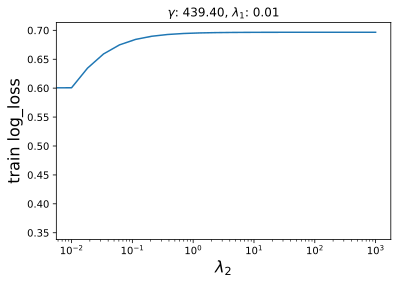

In [875]:
plt.plot(l2_vals, train_errs_cv_3[13][2])
plt.xlabel(r"$\lambda_2$", fontsize=16)
plt.ylabel(r"train log_loss", fontsize=16)
plt.xscale("log")
plt.title(f"$\gamma$: {gammas[13]:.2f}, $\lambda_1$: {l1_vals[2]:.2f}")
# plt.axvline(l2_vals[train_min_idx[2]], color="red", linestyle="--",
#                  label=f"$\lambda_2$ = {l2_vals[train_min_idx[2]]: .3f}")
# plt.legend()

In [882]:
test_errs_3[13][7]

array([0.3661815 , 0.6105968 , 0.64077937, 0.66170635, 0.67495396,
       0.68286496, 0.68742137, 0.68998641, 0.69141116, 0.69219678,
       0.69262679, 0.69286435, 0.69299232, 0.69306159, 0.69310114,
       0.69312203, 0.6931335 , 0.69313968, 0.69314309, 0.69314495,
       0.69314665])

In [812]:

def mae(scores, labels):
  # scores[scores > 0] = 1
  # scores[scores <= 0] = 0
  return np.sum(np.abs(scores - labels)) / float(np.size(labels))

In [15]:
from notebooks.manifold_reg.eval_moses_models import score_moses_models

no_pen_cv = score_moses_models("data/exps4/no_pen", [42], ensemble=True)

print(no_pen_cv["mae"].mean())
no_pen_cv

Evaluating seed 42
0.3


,fold,mae
0,0,0.3
1,1,0.4
2,2,0.2
3,3,0.3
4,4,0.3


In [13]:
no_pen_test = score_moses_models("data/exps4/no_pen_test", [42], test="data/Li2008/beta1_test_165_bin.csv",
                                  combo_file="data/exps4/no_pen_test/seed_42/combo_s_42_f_0.txt" ,ensemble=True)

no_pen_test

0.24

In [11]:
from notebooks.manifold_reg.eval_moses_models import score_moses_models

fold_score_gamma_1 = score_moses_models("data/exps4/gamma_1.39_a_0.36_c1000_contin", [42], ensemble=True)

print(fold_score_gamma_1["mae"].mean())
fold_score_gamma_1

Evaluating seed 42
0.2


,fold,mae
0,0,0.1
1,1,0.2
2,2,0.1
3,3,0.3
4,4,0.3


In [12]:
from notebooks.manifold_reg.eval_moses_models import score_moses_models, score_models

score_gamma_1 = score_moses_models("data/exps4/gamma_1.39_a_28_c1000_contin", [42], test="data/Li2008/beta1_test_165_bin.csv",
                                   combo_file="data/exps4/gamma_1.39_a_28_c1000_contin/seed_42/combo_s_42_f_0.txt", ensemble=True)

score_gamma_1

0.26

In [16]:
from notebooks.manifold_reg.eval_moses_models import score_moses_models

fold_score_gamma_1_norm = score_moses_models("data/exps4/gamma_1.39_a_0.36_c1000_contin_norm", [42], ensemble=True)

print(fold_score_gamma_1_norm["mae"].mean())
fold_score_gamma_1_norm

Evaluating seed 42
0.2


,fold,mae
0,0,0.1
1,1,0.2
2,2,0.1
3,3,0.3
4,4,0.3


In [19]:
X_2, beta_2, y_log_2 = generate_log_data(20, 10, tf_on=4, val_tf=[5, 5, 5, 5], n=100)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_log_2, test_size=0.5, random_state=42, stratify=y_log_2)
save_gen_file(X_train_2, y_train_2, "data/Li2008", "beta1_train", 20, 10)
save_gen_file(X_test_2, y_test_2, "data/Li2008", "beta1_test", 20, 10)

In [21]:
assoc_mat_220 = get_assoc_mat(20, 10)
np.save("data/Li2008/assoc_mat_220.npy", assoc_mat_220)

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from notebooks.manifold_reg.util import solve_logistic_reg
from datetime import datetime

train_errs_4 = np.zeros((len(gammas), n_iter, n_iter))
train_errs_cv_4 = np.zeros((len(gammas), n_iter, n_iter))
test_errs_4 = np.zeros((len(gammas), n_iter, n_iter))
beta_vals_cv_4 = np.zeros((len(gammas), n_iter, n_iter, X_train.shape[1]))
beta_vals_4 = np.zeros((len(gammas), n_iter, n_iter, X_train.shape[1]))

train_ll_pen_4, test_ll_pen_4 = np.zeros((len(gammas), n_iter, n_iter)), np.zeros((len(gammas), n_iter, n_iter))
train_l1_pen_4, test_l1_pen_4 = np.zeros((len(gammas), n_iter, n_iter)), np.zeros((len(gammas), n_iter, n_iter))
train_l2_pen_4, test_l2_pen_4 = np.zeros((len(gammas), n_iter, n_iter)), np.zeros((len(gammas), n_iter, n_iter))

n_folds = 5
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for i, g in enumerate(gammas):
    fold_test_errs_4 = np.zeros((n_folds, n_iter, n_iter))
    fold_beta_vals_4 = np.zeros((n_folds, n_iter, n_iter, X_train.shape[1]))
    fold_ll_pen_4 = np.zeros((n_folds, n_iter, n_iter))
    fold_l1_pen_4 = np.zeros((n_folds, n_iter, n_iter))
    fold_l2_pen_4 = np.zeros((n_folds, n_iter, n_iter))
    j = 0
    print(f"[{datetime.now()}] - gamma - {g:.2f}")
    for train_idx, test_idx in cv.split(X_train, y_train):
        x_train_cv, x_test_cv = X_train[train_idx], X_train[test_idx]
        y_train_cv, y_test_cv = y_train[train_idx], y_train[test_idx]
        _,  fold_test_errs_4[j], fold_beta_vals_4[j],\
                fold_ll_pen_4[j], fold_l1_pen_4[j], fold_l2_pen_4[j] = solve_logistic_reg(x_train_cv, x_test_cv, y_train_cv, y_test_cv, l1_vals, l2_vals, g, assoc_mat, n_iter=n_iter)

        j += 1
    train_errs_cv_4[i] = np.mean(fold_test_errs_4, axis=0)
    beta_vals_cv_4[i] = np.mean(fold_beta_vals_4, axis=0)
    train_ll_pen_4[i] = np.mean(fold_ll_pen_4, axis=0)
    train_l1_pen_4[i] = np.mean(fold_l1_pen_4, axis=0)
    train_l2_pen_4[i] = np.mean(fold_l2_pen_4, axis=0)

    train_errs_4[i], test_errs_4[i], beta_vals_4[i],\
       test_ll_pen_4[i], test_l1_pen_4[i], test_l2_pen_4[i] = solve_logistic_reg(X_train, X_test, y_train, y_test, l1_vals, l2_vals, g, assoc_mat, n_iter=n_iter)

[2022-02-07 20:48:58.184571] - gamma - 0.01
Using numpy cov


In [10]:
res_4 = {"gamma": [], "min_train_err_cv": [], "l1_train_cv": [], "l2_train_cv": [],
         "ll_pen_train_cv": [], "l1_pen_train_cv": [], "l2_pen_train_cv":[],
         "min_test_err": [], "l1_test": [], "l2_test": [],
         "ll_pen_test": [], "l1_pen_test": [], "l2_pen_test": []
         }

for i, g in enumerate(gammas):
    res_4["gamma"].append(g)
    tr_idx = np.unravel_index(np.argmin(train_errs_cv_4[i]), train_errs_cv_4[i].shape)
    te_idx = np.unravel_index(np.argmin(test_errs_4[i]), test_errs_4[i].shape)
    print(f"gamma: {g}, min train idx: {tr_idx}, min test idx: {te_idx}")
    res_4["min_train_err_cv"].append(train_errs_cv_4[i][tr_idx])
    res_4["l1_train_cv"].append(l1_vals[tr_idx[0]])
    res_4["l2_train_cv"].append(l2_vals[tr_idx[1]])
    res_4["ll_pen_train_cv"].append(train_ll_pen_4[i][tr_idx])
    res_4["l1_pen_train_cv"].append(train_l1_pen_4[i][tr_idx])
    res_4["l2_pen_train_cv"].append(train_l2_pen_4[i][tr_idx])

    res_4["min_test_err"].append(test_errs_4[i][te_idx])
    res_4["l1_test"].append(l1_vals[te_idx[0]])
    res_4["l2_test"].append(l2_vals[te_idx[1]])
    res_4["ll_pen_test"].append(test_ll_pen_4[i][te_idx])
    res_4["l1_pen_test"].append(test_l1_pen_4[i][te_idx])
    res_4["l2_pen_test"].append(test_l2_pen_4[i][te_idx])


res_4_df = pd.DataFrame(res_4)
res_4_df

gamma: 0.01, min train idx: (16, 20), min test idx: (20, 0)
gamma: 0.022758459260747887, min train idx: (16, 20), min test idx: (20, 0)
gamma: 0.05179474679231213, min train idx: (16, 0), min test idx: (20, 0)
gamma: 0.11787686347935872, min train idx: (15, 0), min test idx: (20, 0)
gamma: 0.2682695795279726, min train idx: (14, 0), min test idx: (10, 0)
gamma: 0.6105402296585329, min train idx: (14, 0), min test idx: (19, 0)
gamma: 1.3894954943731375, min train idx: (13, 0), min test idx: (11, 0)
gamma: 3.1622776601683795, min train idx: (13, 0), min test idx: (20, 0)
gamma: 7.196856730011521, min train idx: (9, 0), min test idx: (14, 0)
gamma: 16.378937069540648, min train idx: (12, 0), min test idx: (13, 0)
gamma: 37.27593720314942, min train idx: (13, 0), min test idx: (19, 0)
gamma: 84.83428982440725, min train idx: (1, 0), min test idx: (20, 0)
gamma: 193.06977288832496, min train idx: (18, 0), min test idx: (12, 0)
gamma: 439.3970560760795, min train idx: (20, 0), min test idx: 

,gamma,min_train_err_cv,l1_train_cv,l2_train_cv,ll_pen_train_cv,l1_pen_train_cv,l2_pen_train_cv,min_test_err,l1_test,l2_test,ll_pen_test,l1_pen_test,l2_pen_test
0,0.010000,0.594400,0.379269,1000.0,-0.059088,0.418987,0.000000,0.657396,1.000000,0.0,-0.183107,0.263586,0.000000
1,0.022758,0.594400,0.379269,1000.0,-0.059088,0.418987,0.000000,0.657396,1.000000,0.0,-0.183107,0.263586,0.000000
2,0.051795,0.591434,0.379269,0.0,-0.063937,0.423567,302.464088,0.657396,1.000000,0.0,-0.183107,0.263586,0.000000
3,0.117877,0.545375,0.297635,0.0,-0.065133,0.528896,489.724842,0.657391,1.000000,0.0,-0.183102,0.263592,119.718862
4,0.268270,0.584033,0.233572,0.0,-0.213586,0.580173,592.172931,0.656925,0.088587,0.0,-0.240389,0.416039,279.411547
5,0.610540,0.562554,0.233572,0.0,-0.208475,0.543628,538.438832,0.659587,0.784760,0.0,-0.141233,0.310690,178.517301
6,1.389495,0.576294,0.183298,0.0,-0.222011,0.630923,690.831172,0.643479,0.112884,0.0,-0.534619,0.415696,246.098861
7,3.162278,0.548749,0.183298,0.0,-0.377679,0.584274,571.652191,0.656284,1.000000,0.0,-0.182587,0.264273,136.590359
8,7.196857,0.563098,0.069519,0.0,-0.144493,0.865405,1795.018337,0.645840,0.233572,0.0,-0.463752,0.596662,531.054392
9,16.378937,0.565996,0.143845,0.0,-0.336145,0.583910,841.367328,0.608161,0.183298,0.0,-0.355376,0.326004,151.304987


In [29]:
train_errs_cv_4.shape

(15, 21, 21)

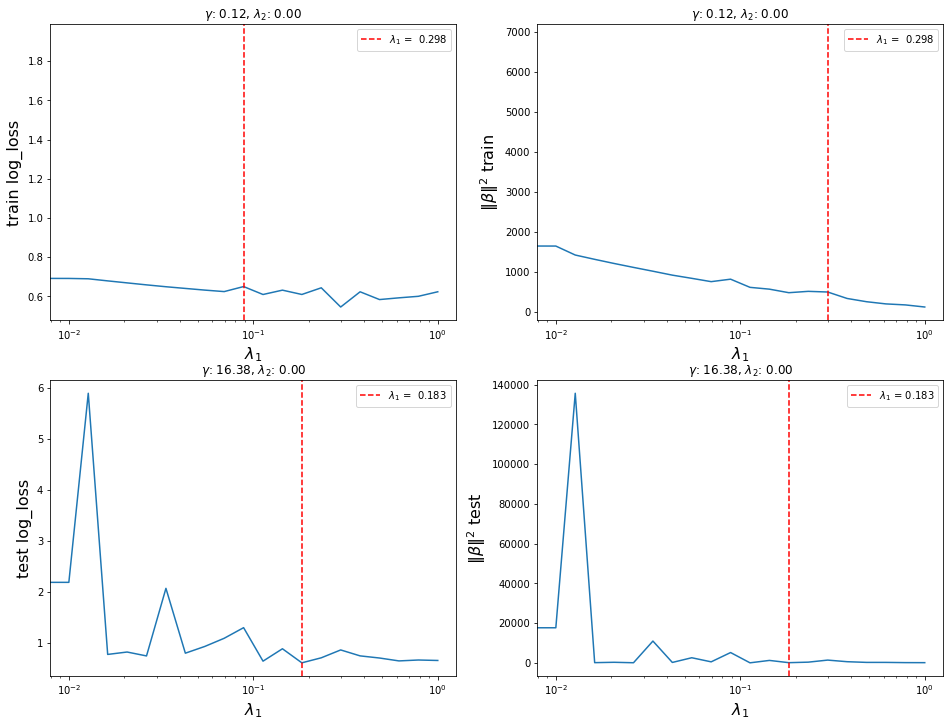

In [25]:
plot_lambda_vals(gammas, train_errs_cv_4, test_errs_4, train_l2_pen_4, test_l2_pen_4, l1_vals, l2_vals)

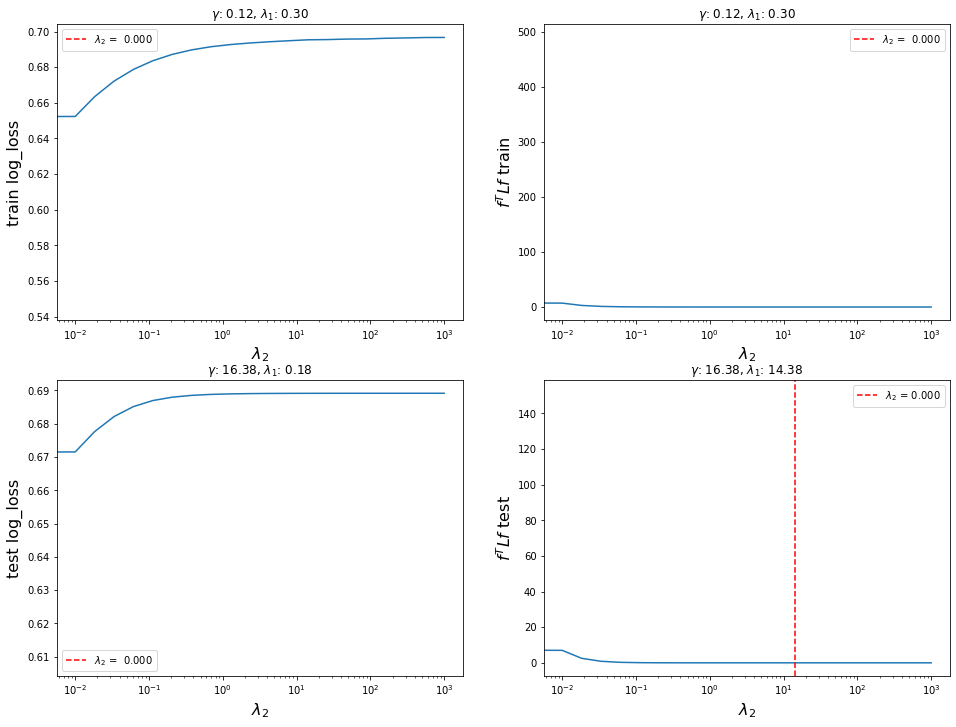

In [23]:
plot_lambda_vals(gammas, train_errs_cv_4, test_errs_4, train_l2_pen_4, test_l2_pen_4, l1_vals, l2_vals, l1=False)

In [35]:
X, beta, y_log = generate_log_data(20, 10, tf_on=4, val_tf=[5, 5, 5, 5], n=5)
prec_mat = get_emp_covariance(X, assoc_mat_220)

Using numpy cov


In [36]:
pd.DataFrame(prec_mat)

,0,1,2,3,4,5,6,7,8,9,...,210,211,212,213,214,215,216,217,218,219
0,0.001078,0.000568,0.000713,0.000191,0.000966,0.000291,0.001328,0.000423,0.000488,0.000436,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000568,0.000322,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000713,0.000000,0.000498,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000191,0.000000,0.000000,0.000142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000966,0.000000,0.000000,0.000000,0.000988,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000342,0.000000,0.000000,0.000000,0.000000
216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000471,0.000000,0.000000,0.000000
217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000588,0.000000,0.000000
218,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000253,0.000000
